### 데이터셋 정보
- 미국 연준 **FRED** (Federal Reserve Economic Data)
- 원/달러(USD/KRW) 1981년~2025년 사이의 일간 환율 데이터
- 정오 고시 스팟 환율이며, 하루 중 하나의 단일 시점(정오) 환율 값

### `01` 40년치 일간 환율 기록 확인

In [1]:
pip install fredapi

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd

# from fredapi import Fred

# # 🔐 API 키 설정
# fred = Fred(api_key='43aefb7ffae287e300464a59c66be7f8')

# # 데이터 시리즈 ID: DEXKOUS (USD/KRW)
# series_id = 'DEXKOUS'

# # 조회 기간 설정: 1981-01-01 ~ 2025-06-30 (현재 시점에 맞게 수정 가능)
# start_date = '1981-01-01'
# end_date = '2025-06-30'

# # FRED API 호출: 일별(frequency='d')
# data = fred.get_series(series_id, observation_start=start_date, observation_end=end_date)

# # 판다스 DataFrame 형태로 변환 및 인덱스 설정
# df = pd.DataFrame(data, columns=['USD/KRW'])
# df.index.name = 'Date'

# # 결과 출력
# print(df.head())
# print(df.tail())
# print(df.info())

# # CSV 파일로 저장 
# df.to_csv('DEXKOUS_USDKRW_daily_1981-2025.csv', index=True)


In [3]:
df = pd.read_csv('DEXKOUS_USDKRW_daily_1981-2025.csv')
df

,Date,USD/KRW
0,1981-04-13,675.40
1,1981-04-14,676.70
2,1981-04-15,676.70
3,1981-04-16,676.70
4,1981-04-17,676.75
...,...,...
11531,2025-06-24,1359.00
11532,2025-06-25,1362.17
11533,2025-06-26,1355.64
11534,2025-06-27,1360.72


In [4]:
print(df.dtypes)

Date        object
USD/KRW    float64
dtype: object


In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.dropna(subset=['Date', 'USD/KRW'])

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10784\3409045941.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df['Date'].dt.year


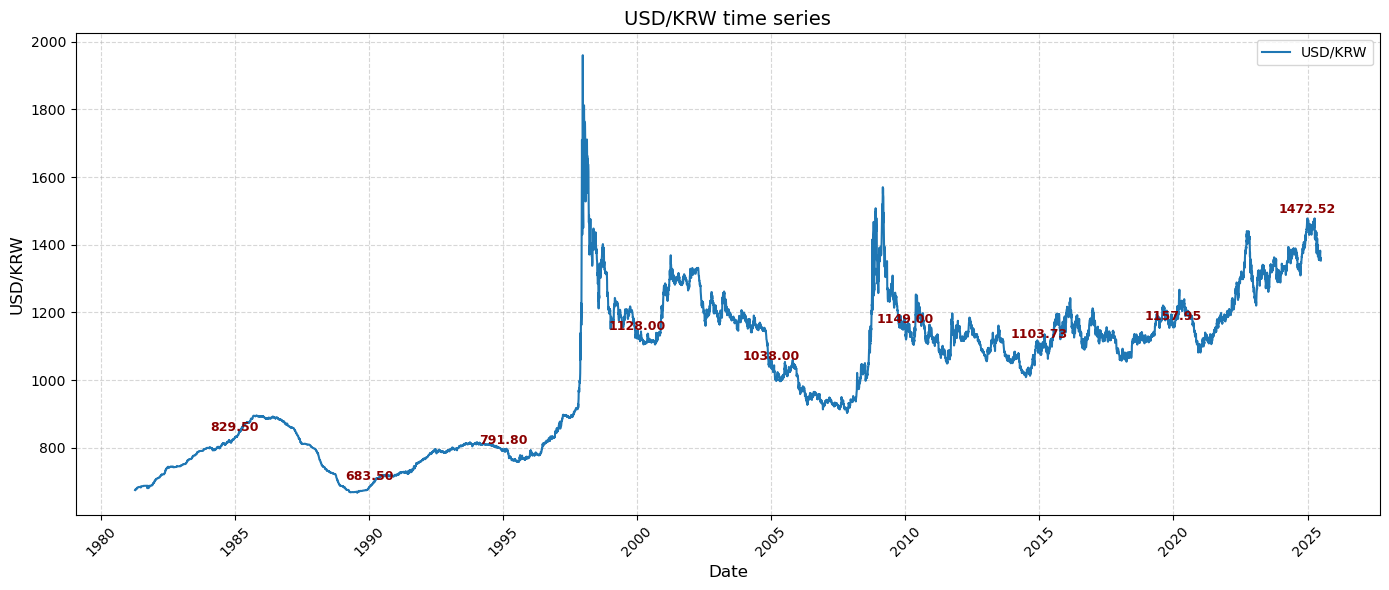

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df['Year'] = df['Date'].dt.year
five_years = df[df['Year'] % 5 == 0]
highlight_points = five_years.groupby('Year').first().reset_index()

plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['USD/KRW'], label='USD/KRW', color='tab:blue')

plt.title('USD/KRW time series', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('USD/KRW', fontsize=12)

locator = mdates.YearLocator(5)           # 5년 단위 눈금
formatter = mdates.DateFormatter('%Y')     # 연도만 표시
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)
plt.xticks(rotation=45)

for _, row in highlight_points.iterrows():
    if pd.notnull(row['Date']) and pd.notnull(row['USD/KRW']):
        plt.annotate(f"{row['USD/KRW']:.2f}",
                     (row['Date'], row['USD/KRW']),
                     textcoords="offset points",
                     xytext=(0, 5),
                     ha='center',
                     fontsize=9, fontweight='bold', color='darkred')

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

### `02` 환율 차익 계산 시뮬레이션
- 3원, 4원, 5원 거래 기준

In [7]:
import pandas as pd
import numpy as np

#### 0) 초기 데이터프레임 생성

In [8]:
# 함수: 거래 장부용 빈 DataFrame 생성
def make_fx_df():
    return pd.DataFrame(columns=[
        'buy_date', 'Won_exchange_rate', 'buy_amount(USD)', 'buy_amount(KRW)',
        'sell_date', 'sell_amount(KRW)', 'margin'
    ])

# 함수: 누적 수익 기록용 빈 DataFrame 생성
def make_total_revenue_df():
    return pd.DataFrame(columns=['date', 'accumulated_revenue'])

FX_arbitrage = {
    3: make_fx_df(),  # FX_arbitrage[3] ← 거래장부
    4: make_fx_df(),
    5: make_fx_df()
}

total_revenue_dict = {
    3: make_total_revenue_df(),  # total_revenue_dict[3] ← 수익기록
    4: make_total_revenue_df(),
    5: make_total_revenue_df()
}

#### 1) 기준값 a에 따라 처리

In [9]:
for a in [3, 4, 5]:
    fx_df = FX_arbitrage[a]  # 해당 a에 해당하는 거래장부 불러오기
    total_revenue = total_revenue_dict[a]  # 해당 a에 해당하는 수익 테이블 불러오기
    accumulated = 0
    prev_rate = None

    for idx, row in df.sort_values('Date').iterrows():
        date = row['Date']  # 현재 날짜
        rate = row['USD/KRW']  # 현재 환율

        if prev_rate is not None:
            # (1) 매수 조건: 환율이 a 이상 하락하면 매수
            if prev_rate - rate >= a:
                buy_usd = 1000
                buy_krw = buy_usd * rate
                fx_df.loc[len(fx_df)] = [  # 거래장부에 매수 기록 추가
                    date, rate, buy_usd, buy_krw,
                    np.nan, np.nan, np.nan
                ]

            # (2) 매도 조건: 매수 후 a 이상 상승 시 매도
            open_trades = fx_df[fx_df['sell_date'].isna()]  # sell_date가 NaN인 매수건 필터링
            for i in open_trades.index:
                row_buy = fx_df.loc[i]
                if rate - row_buy['Won_exchange_rate'] >= a:  # 매수가 대비 a 이상 상승하면 매도
                    sell_krw = 1000 * rate
                    margin = sell_krw - row_buy['buy_amount(KRW)']

                    fx_df.at[i, 'sell_date'] = date
                    fx_df.at[i, 'sell_amount(KRW)'] = sell_krw
                    fx_df.at[i, 'margin'] = margin

                    accumulated += margin  # 누적 수익 증가
                    total_revenue.loc[len(total_revenue)] = [date, accumulated]

        prev_rate = rate  # 전일 환율 업데이트

    # 최종 저장
    FX_arbitrage[a] = fx_df
    total_revenue_dict[a] = total_revenue

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10784\2513495169.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1981-10-05 00:00:00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  fx_df.at[i, 'sell_date'] = date
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10784\2513495169.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1981-10-05 00:00:00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  fx_df.at[i, 'sell_date'] = date
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10784\2513495169.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1981-10-05 00:00:00' has dtype incompatible with float64, please explicitly cast to a

#### 2) 결과 확인

In [10]:
from IPython.display import display

a=3
# 날짜 열을 datetime으로 변환
FX_arbitrage[a]['buy_date'] = pd.to_datetime(FX_arbitrage[a]['buy_date'], errors='coerce')
FX_arbitrage[a]['sell_date'] = pd.to_datetime(FX_arbitrage[a]['sell_date'], errors='coerce')

# sell_date가 있는(=매도 완료된) 행만 필터링
mask_completed = FX_arbitrage[a]['sell_date'].notna()

# 해당 행들에 대해 holding_days 계산
FX_arbitrage[a].loc[mask_completed, 'holding_days'] = (
    FX_arbitrage[a].loc[mask_completed, 'sell_date'] - 
    FX_arbitrage[a].loc[mask_completed, 'buy_date']
).dt.days

# 중앙값 보유일수 계산
median_holding_days = FX_arbitrage[a]['holding_days'].dropna().median()

# margin 열의 평균 (NaN 제외)
mean_margin = FX_arbitrage[a]['margin'].dropna().mean()

# 출력
print(f"\n=== FX_arbitrage_{a}won ===\n")
display(FX_arbitrage[a])
display(total_revenue_dict[a])
print("1000달러씩 거래하여")
print(f"{a}원 기준 중앙값 보유일수: {median_holding_days:.2f}일")
print(f"{a}원 기준 평균 수익 (margin): {mean_margin:,.2f} 원")
print("3원 기준 거래시 45년 누적 수익 :", (total_revenue_dict[a].loc[1954, 'accumulated_revenue'])//10_000, '만원')


=== FX_arbitrage_3won ===



,buy_date,Won_exchange_rate,buy_amount(USD),buy_amount(KRW),sell_date,sell_amount(KRW),margin,holding_days
0,1981-09-25,681.25,1000,681250.0,1981-10-05,688100.0,6850.0,10.0
1,1981-10-06,681.25,1000,681250.0,1981-10-16,685250.0,4000.0,10.0
2,1985-03-19,848.60,1000,848600.0,1985-03-20,852500.0,3900.0,1.0
3,1989-07-26,667.20,1000,667200.0,1989-08-07,670500.0,3300.0,12.0
4,1991-02-12,721.40,1000,721400.0,1991-02-20,725000.0,3600.0,8.0
...,...,...,...,...,...,...,...,...
1967,2025-06-12,1356.47,1000,1356470.0,2025-06-13,1364930.0,8460.0,1.0
1968,2025-06-16,1357.55,1000,1357550.0,2025-06-17,1370290.0,12740.0,1.0
1969,2025-06-24,1359.00,1000,1359000.0,2025-06-25,1362170.0,3170.0,1.0
1970,2025-06-26,1355.64,1000,1355640.0,2025-06-27,1360720.0,5080.0,1.0


,date,accumulated_revenue
0,1981-10-05,6850.0
1,1981-10-16,10850.0
2,1985-03-20,14750.0
3,1989-08-07,18050.0
4,1991-02-20,21650.0
...,...,...
1950,2025-06-13,16963950.0
1951,2025-06-17,16976690.0
1952,2025-06-23,16982880.0
1953,2025-06-25,16986050.0


1000달러씩 거래하여
3원 기준 중앙값 보유일수: 5.00일
3원 기준 평균 수익 (margin): 8,691.12 원
3원 기준 거래시 45년 누적 수익 : 1699.0 만원


In [11]:
a=4
# 날짜 열을 datetime으로 변환
FX_arbitrage[a]['buy_date'] = pd.to_datetime(FX_arbitrage[a]['buy_date'], errors='coerce')
FX_arbitrage[a]['sell_date'] = pd.to_datetime(FX_arbitrage[a]['sell_date'], errors='coerce')

# sell_date가 있는(=매도 완료된) 행만 필터링
mask_completed = FX_arbitrage[a]['sell_date'].notna()

# 해당 행들에 대해 holding_days 계산
FX_arbitrage[a].loc[mask_completed, 'holding_days'] = (
    FX_arbitrage[a].loc[mask_completed, 'sell_date'] - 
    FX_arbitrage[a].loc[mask_completed, 'buy_date']
).dt.days

# 중앙값 보유일수 계산
median_holding_days = FX_arbitrage[a]['holding_days'].dropna().median()

# margin 열의 평균 (NaN 제외)
mean_margin = FX_arbitrage[a]['margin'].dropna().mean()

# 출력
print(f"\n=== FX_arbitrage_{a}won ===\n")
display(FX_arbitrage[a])
display(total_revenue_dict[a])
print("1000달러씩 거래하여")
print(f"{a}원 기준 중앙값 보유일수: {median_holding_days:.2f}일")
print(f"{a}원 기준 평균 수익 (margin): {mean_margin:,.2f} 원")
print("4원 기준 거래시 45년 누적 수익 :", (total_revenue_dict[a].loc[1562, 'accumulated_revenue'])//10_000, '만원')


=== FX_arbitrage_4won ===



,buy_date,Won_exchange_rate,buy_amount(USD),buy_amount(KRW),sell_date,sell_amount(KRW),margin,holding_days
0,1981-09-25,681.25,1000,681250.0,1981-10-05,688100.0,6850.0,10.0
1,1981-10-06,681.25,1000,681250.0,1981-10-16,685250.0,4000.0,10.0
2,1985-03-19,848.60,1000,848600.0,1985-03-21,853400.0,4800.0,2.0
3,1991-06-13,722.90,1000,722900.0,1991-06-18,728400.0,5500.0,5.0
4,1991-06-24,723.90,1000,723900.0,1991-06-25,731400.0,7500.0,1.0
...,...,...,...,...,...,...,...,...
1577,2025-06-12,1356.47,1000,1356470.0,2025-06-13,1364930.0,8460.0,1.0
1578,2025-06-16,1357.55,1000,1357550.0,2025-06-17,1370290.0,12740.0,1.0
1579,2025-06-24,1359.00,1000,1359000.0,NaT,NaN,NaN,NaN
1580,2025-06-26,1355.64,1000,1355640.0,2025-06-27,1360720.0,5080.0,1.0


,date,accumulated_revenue
0,1981-10-05,6850.0
1,1981-10-16,10850.0
2,1985-03-21,15650.0
3,1991-06-18,21150.0
4,1991-06-25,28650.0
...,...,...
1558,2025-06-11,15536740.0
1559,2025-06-13,15545200.0
1560,2025-06-17,15557940.0
1561,2025-06-23,15564130.0


1000달러씩 거래하여
4원 기준 중앙값 보유일수: 6.00일
4원 기준 평균 수익 (margin): 9,961.11 원
4원 기준 거래시 45년 누적 수익 : 1556.0 만원


In [12]:
a=5
# 날짜 열을 datetime으로 변환
FX_arbitrage[a]['buy_date'] = pd.to_datetime(FX_arbitrage[a]['buy_date'], errors='coerce')
FX_arbitrage[a]['sell_date'] = pd.to_datetime(FX_arbitrage[a]['sell_date'], errors='coerce')

# sell_date가 있는(=매도 완료된) 행만 필터링
mask_completed = FX_arbitrage[a]['sell_date'].notna()

# 해당 행들에 대해 holding_days 계산
FX_arbitrage[a].loc[mask_completed, 'holding_days'] = (
    FX_arbitrage[a].loc[mask_completed, 'sell_date'] - 
    FX_arbitrage[a].loc[mask_completed, 'buy_date']
).dt.days

# 중앙값 보유일수 계산
median_holding_days = FX_arbitrage[a]['holding_days'].dropna().median()

# margin 열의 평균 (NaN 제외)
mean_margin = FX_arbitrage[a]['margin'].dropna().mean()

# 출력
print(f"\n=== FX_arbitrage_{a}won ===\n")
display(FX_arbitrage[a])
display(total_revenue_dict[a])
print("1000달러씩 거래하여")
print(f"{a}원 기준 중앙값 보유일수: {median_holding_days:.2f}일")
print(f"{a}원 기준 평균 수익 (margin): {mean_margin:,.2f} 원")
print("5원 기준 거래시 45년 누적 수익 :", (total_revenue_dict[a].loc[1214, 'accumulated_revenue'])//10_000, '만원')


=== FX_arbitrage_5won ===



,buy_date,Won_exchange_rate,buy_amount(USD),buy_amount(KRW),sell_date,sell_amount(KRW),margin,holding_days
0,1981-09-25,681.25,1000,681250.0,1981-10-05,688100.0,6850.0,10.0
1,1981-10-06,681.25,1000,681250.0,1981-10-30,688250.0,7000.0,24.0
2,1991-06-13,722.90,1000,722900.0,1991-06-18,728400.0,5500.0,5.0
3,1992-07-10,783.70,1000,783700.0,1992-07-13,790200.0,6500.0,3.0
4,1993-04-15,792.90,1000,792900.0,1993-04-16,799000.0,6100.0,1.0
...,...,...,...,...,...,...,...,...
1229,2025-06-12,1356.47,1000,1356470.0,2025-06-13,1364930.0,8460.0,1.0
1230,2025-06-16,1357.55,1000,1357550.0,2025-06-17,1370290.0,12740.0,1.0
1231,2025-06-24,1359.00,1000,1359000.0,NaT,NaN,NaN,NaN
1232,2025-06-26,1355.64,1000,1355640.0,2025-06-27,1360720.0,5080.0,1.0


,date,accumulated_revenue
0,1981-10-05,6850.0
1,1981-10-30,13850.0
2,1991-06-18,19350.0
3,1992-07-13,25850.0
4,1993-04-16,31950.0
...,...,...
1210,2025-06-10,13660970.0
1211,2025-06-13,13669430.0
1212,2025-06-17,13675560.0
1213,2025-06-17,13688300.0


1000달러씩 거래하여
5원 기준 중앙값 보유일수: 7.00일
5원 기준 평균 수익 (margin): 11,270.27 원
5원 기준 거래시 45년 누적 수익 : 1369.0 만원


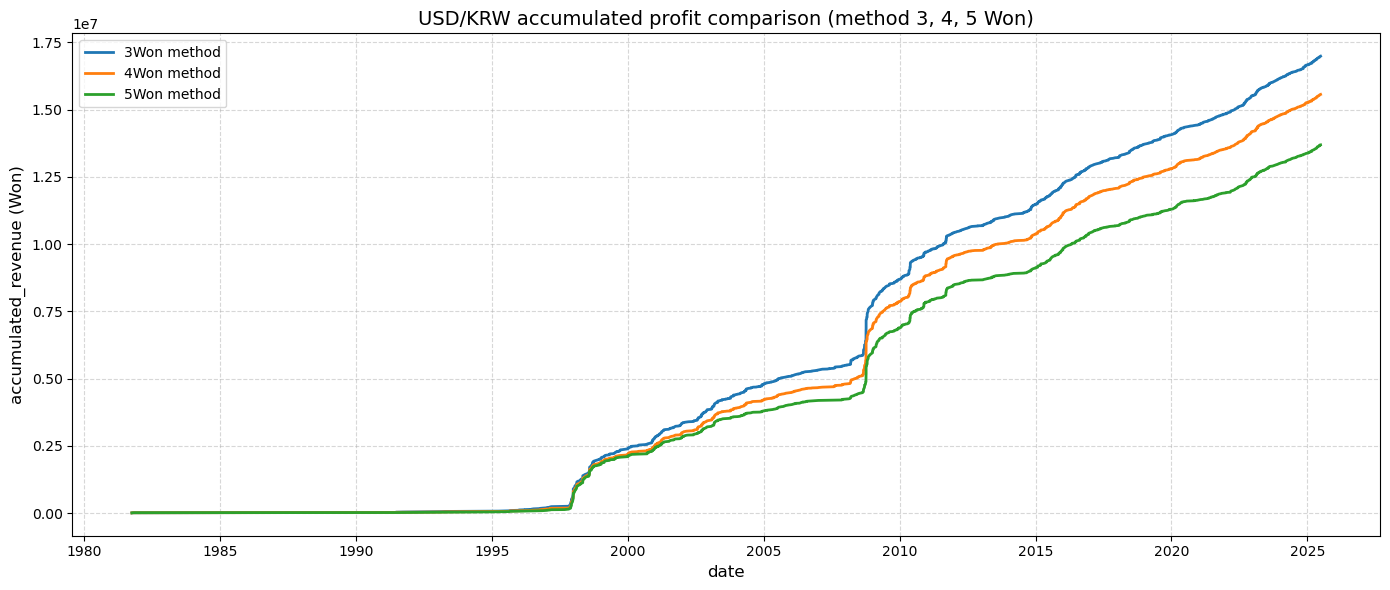

In [13]:
plt.figure(figsize=(14, 6))  # 그래프 사이즈 지정

# 3원 기준 누적 수익 그래프
plt.plot(total_revenue_dict[3]['date'], total_revenue_dict[3]['accumulated_revenue'],
         label='3Won method', linewidth=2)

# 4원 기준 누적 수익 그래프
plt.plot(total_revenue_dict[4]['date'], total_revenue_dict[4]['accumulated_revenue'],
         label='4Won method', linewidth=2)

# 5원 기준 누적 수익 그래프
plt.plot(total_revenue_dict[5]['date'], total_revenue_dict[5]['accumulated_revenue'],
         label='5Won method', linewidth=2)

# 그래프 제목 및 축 레이블
plt.title('USD/KRW accumulated profit comparison (method 3, 4, 5 Won)', fontsize=14)
plt.xlabel('date', fontsize=12)
plt.ylabel('accumulated_revenue (Won)', fontsize=12)

# 범례, 격자, 기타 설정
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()